# Data Science Projekt Robert Scheer

## Einleitung

In diesem Projekt werden Flugdaten amerikanischer Inlandsfluege von 2018 bis 2022 untersucht.
Das Datenset beinhaltet ueber 26 Millionen Fluege, jeweils mit Start und Zielflughafen, Airline, Flugnummer und Start- und Landeverspaetung.

*Wenn in diesem Projekt von Verspaetung geredet wird, ist ab hier die Landeverspaetung gemeint, da diese fuer Kunden bzw Passagiere ausschlaggebender ist.*

Genauer gesagt werden folgende Hypothesen ueberprueft:

1. Fluege im Winter haben haeufiger Verspaetungen.
2. Langstreckefluege haben weniger Verspaetungen als Kurzstreckenfluege.
3. Fluege mit grossen Zielflughaefen haben, falls sie Verspaetungen haben, groessere Verspaetungen als Fluege mit kleineren Zielflughaefen.

Aussderdem wird untersucht, ob die Verspaetung eines Flugs mittels eines Neuronalen Netz vorhersagbar ist.
Es wird auch untersucht, welche Merkmale ausschlaggebend sind.

## Imports

Zuerst werden die benoetigten Module importiert.
Das src Modul implementiert Methoden, die spezifisch fuer das Projekt erstellt wurden.
Damit das src Modul importiert werden kann, muss der Ordner zum path hinzugefuegt werden.

In [1]:
import sys
import os
import random

import pandas as pd
import numpy as np
import scipy.stats as stats

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), ".."))) # Wird nach Ausfuerung zurueckgesetzt

## Laden der Daten

Hier wird der Datensatz zuerst als zip datei runtergeladen, dann exportiert und gefiltert.
Der Download betraegt ca. 4GB, es kann also eine Weile dauern, bis er fertig heruntergeladen ist.

Beim Filtern werden ueberfluessige Spalten aus den Daten geloescht, um die Groesse des Datensatzes zu reduzieren.
Dabei geht die Groesse des extrahierten Datensatzes von 9GB auf 4.5GB herunter.

In [2]:
import src.data.folders
import src.data.download
import src.data.extract
import src.data.filter
import src.data.loading

src.data.folders.dataset_folders()
src.data.download.dataset_download(auto_skip=True)
src.data.extract.dataset_extract(auto_skip=True)
src.data.filter.dataset_filter(auto_skip=True)

data = src.data.loading.load_all()

Auto Skipping Download...
Auto Skipping extraction...
Auto Skipping filtration...
Loading full dataset...


Loaded 29193782 flights!


## Visualisierungen

Hier wird der Datensatz visualiert, um ein Gefuehl fuer die Daten zu bekommen.

Zufaellig ausgewaehlter Datenpunkt: 
FlightDate: 2019-12-28
Airline: Delta Air Lines Inc.
Cancelled: False
Diverted: False
CRSDepTime: 1853
DepTime: 1847.0
DepDelay: -6.0
ArrTime: 2130.0
ArrDelay: -20.0
AirTime: 144.0
CRSElapsedTime: 177.0
ActualElapsedTime: 163.0
Distance: 1084.0
DayOfWeek: 6
Operating_Airline: DL
Tail_Number: N866DN
Flight_Number_Operating_Airline: 2343
OriginCityName: Fort Myers, FL
OriginStateName: Florida
DestCityName: Detroit, MI
DestStateName: Michigan
CRSArrTime: 2150


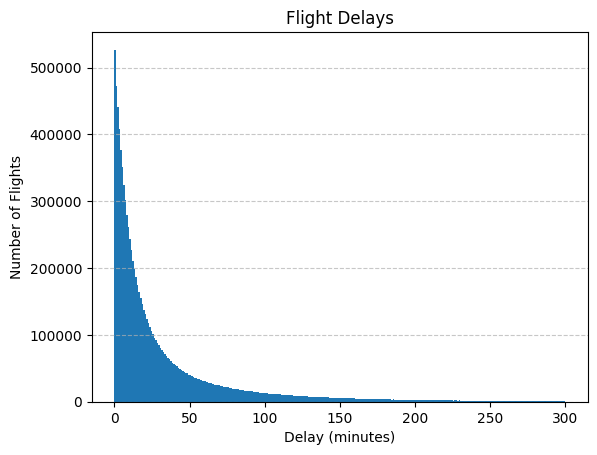

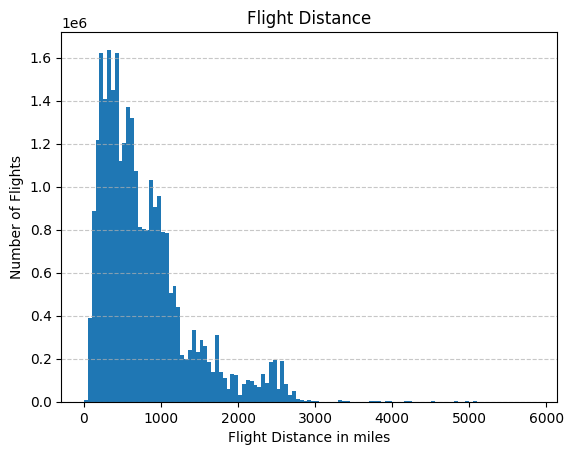

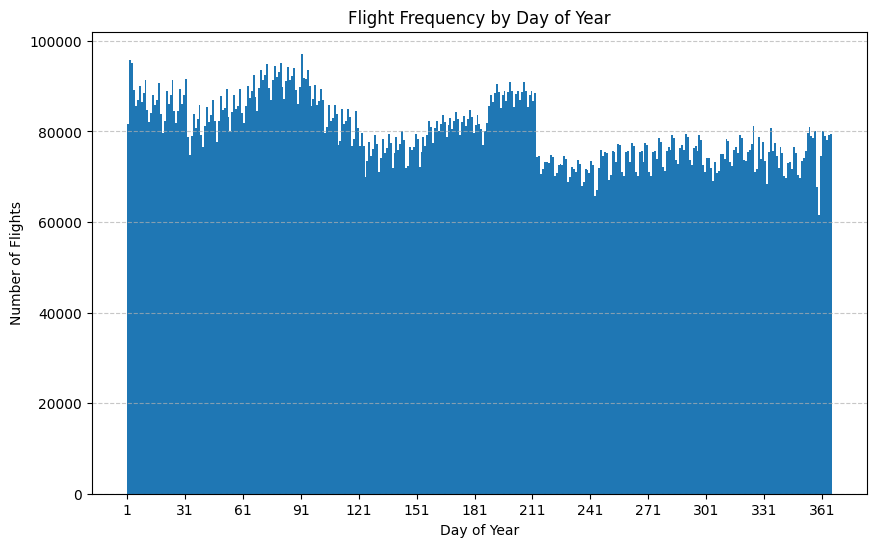

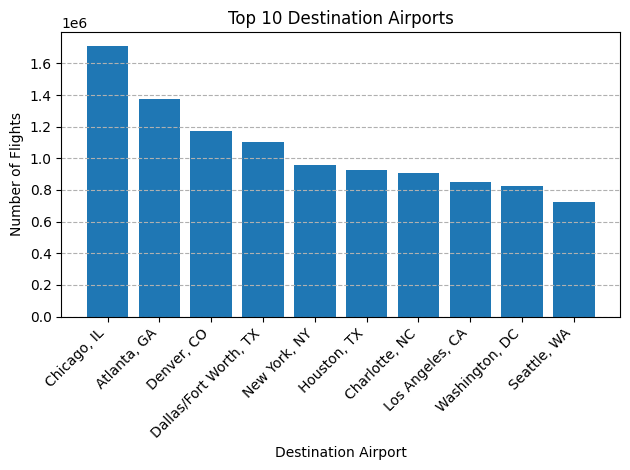

In [3]:
import src.visualization
import src.visualization.visualize


print("Zufaellig ausgewaehlter Datenpunkt: ")
[print(f"{col}: {val}") for col, val in data.iloc[random.randint(0, len(data)-1)].items()]

src.visualization.visualize.plot_delay(data)
src.visualization.visualize.plot_distance(data)
src.visualization.visualize.plot_yearly_activities(data)
src.visualization.visualize.plot_top_airports(data, 10)

Von [Wikipedia](https://en.wikipedia.org/wiki/O%27Hare_International_Airport):
> As of 2024, O'Hare (Chicaco Airport) is considered the most connected airport in the US...

Dies deutet darauf hin, dass die Daten schlüssig und zuverlässig sind.

## Hypothesentests

### Hypothese 1

Hypothese: **Fluege im Winter haben haeufiger Verspaetungen**

Als Winter werden die Monate Dezember, Januar und Februar definiert.
Die genaue Dauer der Verspaetung ist hierbei egal, als signifikante Verspaetung wird hier eine Verspaetung von mehr als 15 Minuten festgelegt.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Haeufigkeit der Verspaetungen zwischen Winter- und nicht Winter Fluegen.

Alternativhypothese $H_1$: Flüge im Winter haben häufiger Verspätungen.

In [4]:
winter_months = {12, 1, 2}

# Neue Spalte für Winter/Nicht-Winter erstellen
data["Winter"] = data["FlightDate"].apply(lambda x: pd.to_datetime(x).month in winter_months)

# Verspätung definieren
data["Delayed"] = (data["ArrDelay"] > 15).astype(int)

# Anteil verspäteter Flüge in Winter- und Nicht-Winter-Monaten
winter_delays = data[data["Winter"]]["Delayed"]
non_winter_delays = data[~data["Winter"]]["Delayed"]

# Chi-Quadrat-Test für Häufigkeiten
contingency_table = pd.crosstab(data["Winter"], data["Delayed"])
chi2_stat, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Quadrat-Wert: {chi2_stat}, p-Wert: {p}")

t_stat, p_ttest = stats.ttest_ind(winter_delays, non_winter_delays, equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")


Chi-Quadrat-Wert: 608.6484451553758, p-Wert: 2.2014843185196696e-134
t-Wert: 24.556822938967155, p-Wert: 3.6835485125626365e-133


Da die p-Werte beider Tests deutlich kleiner als $0.05$ sind, kann die Nullhypothese mit Sicherheit verworfen werden.

**Dadurch ist bestaetigt, dass Fluege im Winter haeufiger Verspaetungen haben!**

### Hypothese 2

Hypothese: **Langstreckefluege haben weniger haeufig Verspaetungen als Kurzstreckenfluege.**

Als Verspaetung wird wieder jede Verspaetung ueber 15 Minuten gewertet. Ein Langstreckenflug wird als Flug mit ueber 1000 Meilen Distanz festgelegt.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Haeufigkeit der Verspaetungen zwischen Lang- und Kurzstreckenfluegen.

Alternativhypothese $H_1$: Langstreckefluege haben weniger haeufig Verspaetungen als Kurzstreckenfluege.

In [5]:
# Langstreckenflug = mehr als 1000 Meilen, Verspaetung ist schon bei Hypothese 1 definiert
data["LongHaul"] = data["Distance"] > 1000

long_haul_delays = data[data["LongHaul"]]["Delayed"]
short_haul_delays = data[~data["LongHaul"]]["Delayed"]

# Chi-Quadrat-Test für Häufigkeiten
contingency_table = pd.crosstab(data["LongHaul"], data["Delayed"])
chi2_stat, p_chi2, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-Quadrat-Wert: {chi2_stat}, p-Wert: {p_chi2}")

# t-Test für Mittelwertvergleich
t_stat, p_ttest = stats.ttest_ind(long_haul_delays.astype(int), short_haul_delays.astype(int), equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")

Chi-Quadrat-Wert: 11672.72307877028, p-Wert: 0.0
t-Wert: 106.01171381948066, p-Wert: 0.0


Der p-Wert von $0.0$ beider Tests zeigt, dass die Nullhypothese $H_0$ verworfen werden kann.

### Hypothese 3

Hypothese: **Fluege mit grossen Zielflughaefen haben, falls sie Verspaetungen haben, groessere Verspaetungen als Fluege mit kleineren Zielflughaefen.**

Als Verspaetung wird wieder jede Verspaetung ueber 15 Minuten gewertet.

Ein grosser Flughafen ist ein Flughafen in den oberen 1% der meist besuchten Flughaefen.

Nullhypothese $H_0$: Es gibt keinen Unterschied in der Laenge der Verspaetungen zwischen grossen und kleinen Flughaefen.

Alternativhypothese $H_1$: An größeren Flughäfen gibt es größere Verspätungen, falls eine Verspätung auftritt.

In [6]:
# Flughäfen mit den höchsten Passagierzahlen (Top 1%)
airport_counts = data['DestCityName'].value_counts()
top_1_percent_airports = airport_counts[airport_counts > airport_counts.quantile(0.99)].index

data['LargeAirport'] = data['DestCityName'].isin(top_1_percent_airports)
data['Delayed'] = data['ArrDelay'] > 15
delayed_flights = data[data['Delayed']]

large_airport_delays = delayed_flights[delayed_flights['LargeAirport']]['ArrDelay']
small_airport_delays = delayed_flights[~delayed_flights['LargeAirport']]['ArrDelay']

t_stat, p_ttest = stats.ttest_ind(large_airport_delays, small_airport_delays, equal_var=False)
print(f"t-Wert: {t_stat}, p-Wert: {p_ttest}")

u_stat, p_u = stats.mannwhitneyu(large_airport_delays, small_airport_delays, alternative="greater")
print(f"Mann-Whitney-U-Wert: {u_stat}, p-Wert: {p_u}")

t-Wert: 67.21169329627793, p-Wert: 0.0
Mann-Whitney-U-Wert: 1731245843630.5, p-Wert: 0.0


Der p-Wert von $0.0$ beider Tests bedeutet, dass die Nullhypothese verworfen werden kann.

Daraus folgt, dass die Alternativhypothese wahr ist.

### Exkurs: Ueberpruefung der p-Werte

Die p-Werte von $0.0$ der letzten beiden Tests haben mich skeptisch gemacht, da ich nicht so ein deutliches Ergebnis erwartet haette.

Eine [Google-Suche](https://www.nature.com/articles/s41598-021-00199-5) deutet darauf hin, dass die p-Werte bei grossen Datensaetzen (zB einem wie der hier vorliegt) generell kleiner sind. 

Dadurch sind die Unterschiede zwar statistisch signifikant, allerdings sind die Auswirkungen in der realen Welt nicht unbedingt relevant.

Um die Auswirkungen zu berechnen, kann mit [Cohan's d](https://novustat.com/statistik-blog/cohens-d-effektstaerke-berechnen.html) die sogenannte Effektstaerke berechnet werden.

Ein $d$-Wert in $[0, 0.2]$ zeigt hierbei einen kleinen bzw. keinen Effekt, <br>
in $[0.2, 0.5]$ einen geringen Effekt, <br>
in $[0.5, 0.8]$ einen mittleren und ab $0.8$ einen grossen Effekt.

Im folgenden wird die Effektstaerke fuer alle drei Hypothesen berechnet.

In [7]:
winter_delays = data[data["Winter"]]["Delayed"]
non_winter_delays = data[~data["Winter"]]["Delayed"]
mean_winter = winter_delays.mean()
mean_non_winter = non_winter_delays.mean()
std_winter = winter_delays.std()
std_non_winter = non_winter_delays.std()
pooled_std_1 = np.sqrt((std_winter**2 + std_non_winter**2) / 2)
cohen_d_1 = (mean_winter - mean_non_winter) / pooled_std_1
print(f"Hypothese 1 - Cohen's d: {cohen_d_1:.3f}")

long_haul_delays = data[data["LongHaul"]]["Delayed"]
short_haul_delays = data[~data["LongHaul"]]["Delayed"]
mean_long = long_haul_delays.mean()
mean_short = short_haul_delays.mean()
std_long = long_haul_delays.std()
std_short = short_haul_delays.std()
pooled_std_2 = np.sqrt((std_long**2 + std_short**2) / 2)
cohen_d_2 = (mean_long - mean_short) / pooled_std_2
print(f"Hypothese 2 - Cohen's d: {cohen_d_2:.3f}")

mean_large = large_airport_delays.mean()
mean_small = small_airport_delays.mean()
std_large = large_airport_delays.std()
std_small = small_airport_delays.std()
pooled_std = np.sqrt((std_large**2 + std_small**2) / 2)
cohen_d_3 = (mean_large - mean_small) / pooled_std
print(f"Hypothese 3 - Cohen's d: {cohen_d_3:.3f}")

Hypothese 1 - Cohen's d: 0.010
Hypothese 2 - Cohen's d: 0.045
Hypothese 3 - Cohen's d: 0.086


Die d-Werte für alle drei Hypothesen sind sehr klein (unter 0.2), was darauf hinweist, dass die Unterschiede in den Verspätungen zwischen den verglichenen Gruppen praktisch nicht relevant sind.<br>Obwohl die Unterschiede statistisch signifikant sein könnten, sind sie aus praktischer Sicht vernachlässigbar.

## Neuronales Netz

Im folgenden wird ein Neuronales Netz trainiert, um aufgrund der Eckdaten die Verspaetung vorhersagen zu koennen.

Es wird pytorch statt sklearn verwendet, um das Training auf der GPU durchfuehren zu koennen. 
Auf der CPU wuerde ein Datensatz dieser Groesse sehr lange dauern zum Trainieren.

Als Merkmale wurden ausgewaehlt:
- Distanz des Flugs `Distance`
- Startflughafen Rang `DepRank` \*
- Zielflughafen Rang `DestRank` \*
- Airline Rang `AirlineRank` \*
- Tag des Jahres `DayOfYear` \*
- Wochentag `DayOfWeek`

*Merkmale, die mit einem \* versehen sind, werden noch extrahiert.*

Die vom Neuronalen Netz zu berechnende Variable ist dann die Verspaetung bei Ankunft, also `ArrDelay`.

Als Metrik wird der Mean Squared Error zwischen der geschaetzten Ankunftszeit und der tatsaechlichen Ankunftszeit gewaehlt.

In [8]:
import src.features
import src.features.build_features

data = src.features.build_features.build_airline_rank(data)
data = src.features.build_features.build_day_of_year(data)
data = src.features.build_features.build_dep_airport_rank(data)
data = src.features.build_features.build_dest_airport_rank(data)

# # Alle Daten auf das Zielgeraet schieben und dabei skalieren
# train_data_device = move_data(train_data, device)
# val_data_device = move_data(val_data, device)
# test_data_device = move_data(test_data, device)

Im folgenden wird der Dataframe zu den NN-Kompatiblen Daten gewandelt.

In [9]:
import src.models
import src.models.network
import torch

merkmale = ["Distance", "DepRank", "DestRank", "AirlineRank", "DayOfYear", "DayOfWeek"]

x = torch.tensor(data[merkmale].values, dtype=torch.float32)
y = torch.tensor(data["ArrDelay"].values, dtype=torch.float32)

print(x.shape, y.shape)

nn_data = src.models.network.Flights_Data(x, y)

torch.Size([29193782, 6]) torch.Size([29193782])


Hier wird geschaut, ob eine Grafikkarte zur Beschleunigung verfuegbar ist. Falls ja, wird diese fuer das Trainieren und Testen des NN verwendet.
Dann werden die Daten in ein Trainings-, Validierungs- und Testsubset aufgeteilt und dann auf das Zielgeraet (CPU/GPU) verschoben.
Danach werden die DataLoader erstellt, um die Daten in Batches beim Trainieren zu Laden.

In [10]:
device = src.models.network.get_device(mute=False)

nn_data_train, nn_data_val, nn_data_test = src.models.network.split_data(nn_data)

if device != "cpu":
    nn_data_train = src.models.network.move_data(nn_data_train, device)
    nn_data_val = src.models.network.move_data(nn_data_val, device)
    nn_data_test = src.models.network.move_data(nn_data_test, device)

train_loader = torch.utils.data.DataLoader(
    nn_data_train,
    batch_size=512,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    nn_data_val,
    batch_size=512,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    nn_data_test,
    batch_size=512,
    shuffle=True
)

Using CPU


Im folgenden wird das Netz erstellt.
Das Netz besteht aus zwei hintereinander geschalteten Bloecken, um verschiedene Regularisierungsmethoden testen zu koennen.

Als Performance Metiken wurden der MeanSquaredError und der R2Score gewaehlt.

Der MSE gibt den durchschnittlichen Fehler zwischen der geschaetzten und echten Ankunftszeit an. Das Ergebnis wird quadriert, um groessere Fehler mehr zu bestrafen.
Der R2Score zeigt, wie gut die Vorhersagen des Netzes sind.
Ein R2Score von $\le 0$ bedeutet eine schlechtere Vorhersage als eine Mittelwert-Vorhersage, ein R2Score $>0$ eine gute, und ein R2Score von $1$ eine perfekte Vorhersage.

In [13]:
from torch import nn

from torchmetrics import MeanAbsoluteError, R2Score

network = src.models.network.MLP(2, 2, 
             num_in=6, 
             num_out=1,
             hidden_size=256,
             skip_connections=True,
             activ=nn.ReLU(),
             dropout=0.2).to(device)

optimizer = torch.optim.AdamW(network.parameters(), lr=0.00001)
loss_fn = nn.MSELoss().to(device)
acc = MeanAbsoluteError().to(device)

max_epochs = 100

batch_set_size = 500

for e in range(max_epochs):
    acc.reset()
    network.train()

    batch_count = 0
    print("\rRebatching...", end="")
    train_loader = torch.utils.data.DataLoader(nn_data_train, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)

    for x, y in train_loader:
        batch_count += 1
        print("\r", batch_count, " "*20, end="")
        x = x.float()
        y = y.float().view(-1, 1)
        optimizer.zero_grad()
        logits = network(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        acc(logits, y)

        if batch_count >= batch_set_size:
            break
    
    train_acc = acc.compute()
    val_acc, val_loss = src.models.network.test_network(network, nn_data_val, 100, acc, loss_fn)

    print(f"\rEpoch {e+1:>3}/{max_epochs}: Train_acc: {train_acc:.3f}   Val_acc: {val_acc:.3f}    Val loss: {val_loss:.5f}")


Epoch   1/100: Train_acc: 265280029426974720.000   Val_acc: 278502601643786240.000    Val loss: inf
 500                     

KeyboardInterrupt: 